<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/II-SoTA/OpenVocab_OD_GroundingDINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*GPU mandatory ? No*

## Download the model from HuggingFace

In [ ]:
import requests
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import numpy as np # For color generation if needed

# --- Model and Processor Loading (same as before) ---
model_id = "IDEA-Research/grounding-dino-base"
# model_id = "IDEA-Research/grounding-dino-tiny" is another option with faster inference and less parameters

device = "cuda" if torch.cuda.is_available() else "cpu" # Use CUDA if available, else CPU

## Preprocessing

In [ ]:
# Processor describes the transformations applied to the input data (images and text labels)
processor = AutoProcessor.from_pretrained(model_id)
processor

## Downloading and inspecting the model

In [ ]:
# Download and inspect the model, send it to GPU if available
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
model

## Image loading

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

image_path = "/gdrive/MyDrive/Colab Notebooks/Portfolio/SoTA/pineapple-sits-table-with-other-fruits_726745-5475-3767101720.jpg"
image = Image.open(image_path).convert("RGB")

Mounted at /gdrive


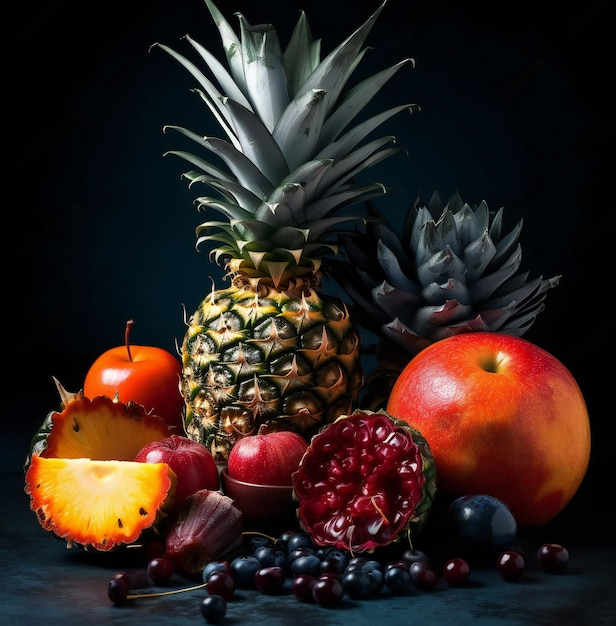

In [ ]:
image


## Defining Open-Vocabulary Text Labels

In [ ]:
# Or a simple list of strings for distinct concepts.
text_labels = ["a pineapple"] # This means "find objects that are ..."



In [ ]:
# --- Inference (Getting Predictions)  ---
inputs = processor(images=image, text=text_labels, return_tensors="pt", padding=True).to(device)
with torch.inference_mode():
    outputs = model(**inputs)



In [ ]:
# Inspecting the format of outputs, notice that we get not only the predictions (in logits and pred_boxes) but also hidden states for the model
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'init_reference_points', 'intermediate_hidden_states', 'intermediate_reference_points', 'encoder_last_hidden_state_vision', 'encoder_last_hidden_state_text', 'enc_outputs_class', 'enc_outputs_coord_logits', 'encoder_logits', 'encoder_pred_boxes', 'input_ids'])



## Filtering the Output with Confidence Thresholds

In [ ]:

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    #box_threshold=0.4, # Confidence threshold for a box to be considered
    text_threshold=0.3, # Confidence threshold for a label to be assigned to a box
    target_sizes=[image.size[::-1]] # (height, width)
)

result = results[0] # We process one image at a time
print(f"Detected {len(result['scores'])} objects.")



Detected 1 objects.


In [ ]:
# Create a drawable version of the image
draw = ImageDraw.Draw(image)

# Define some colors for different labels (optional, can cycle or use a fixed color)
# Get unique labels to assign colors
unique_labels = list(set(result["labels"]))
# Generate some distinct colors
# Using a simple approach with a predefined list, cycling if more labels than colors
palette = ["red", "green", "blue", "yellow", "purple", "orange", "cyan", "magenta"]
label_to_color = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


## Plotting the bounding boxes

Detected 'a pineapple' with confidence 0.755 at location [148.47, 3.22, 420.08, 465.46]


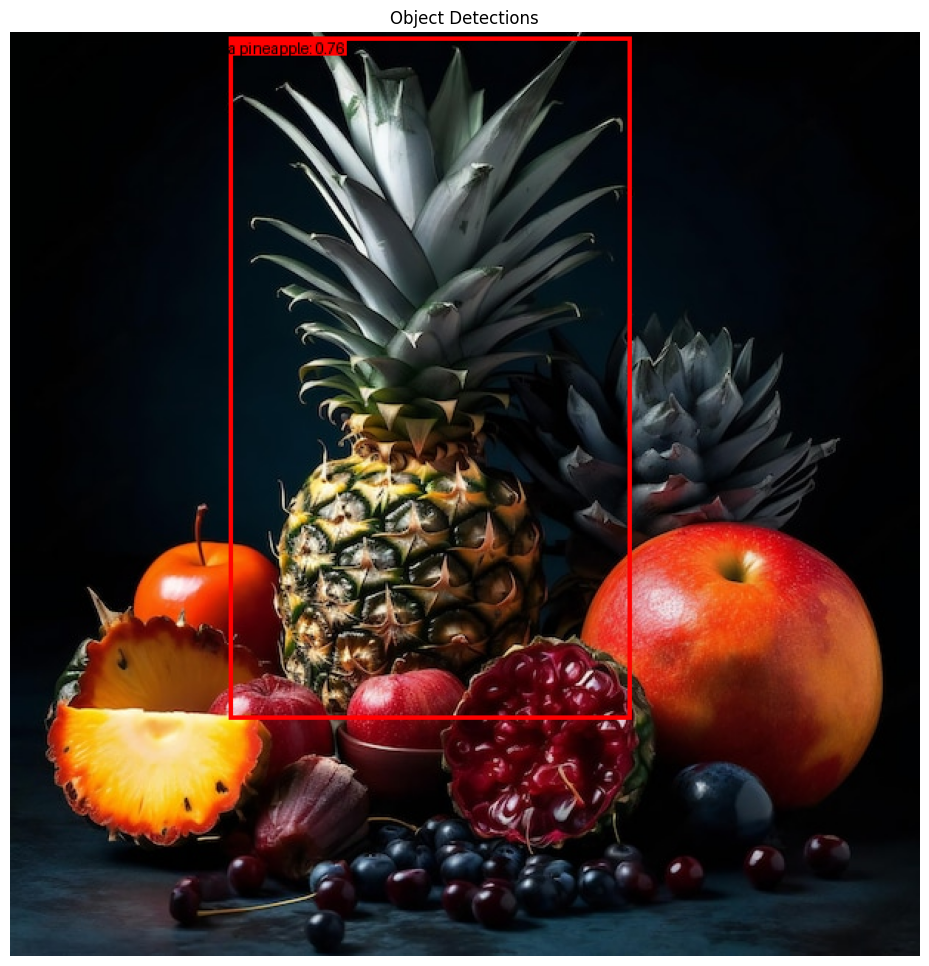

In [ ]:
for box_tensor, score_tensor, label_str in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(i, 2) for i in box_tensor.tolist()] # [xmin, ymin, xmax, ymax]
    score = round(score_tensor.item(), 3)
    color = label_to_color.get(label_str, "white") # Default to white if label somehow not in map

    # Draw bounding box
    draw.rectangle(box, outline=color, width=3)

    # Prepare text: label and confidence
    text = f"{label_str}: {score:.2f}"

    # Calculate text size and position
    # For PIL versions < 9.2.0, textsize is used. For >= 9.2.0, textbbox is preferred.
    try:
        text_bbox = draw.textbbox((box[0], box[1]), text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
    except AttributeError: # Fallback for older PIL
        text_width, text_height = draw.textsize(text)


    # Position text slightly above the box, or inside if it goes off-screen
    text_x = box[0]
    text_y = box[1] - text_height - 2 # A little padding above the box

    if text_y < 0: # If text goes off the top screen, place it inside the box at the top
        text_y = box[1] + 2
    if text_x + text_width > image.width: # If text goes off the right screen
        text_x = image.width - text_width -2


    # Draw a filled rectangle as a background for the text for better visibility
    draw.rectangle(
        [text_x, text_y, text_x + text_width, text_y + text_height],
        fill=color
    )
    # Draw the text
    draw.text((text_x, text_y), text, fill="black") # Black text on colored background

    print(f"Detected '{label_str}' with confidence {score} at location {box}")

# --- Display the image with detections ---
plt.figure(figsize=(12, 12)) # You can adjust the figure size
plt.imshow(image)
plt.axis('off') # Hide axes
plt.title("Object Detections")
plt.show()

